# Classification and Forecasting of Water Stress in Tomato Plants using Bioristor Data

## Manuele Bettelli, Filippo Vurro, Riccardo Pecori, Michela Janni,Nicola Coppedè, Andrea Zappettini, Daniele Tessera

## Code Version 1.0

### For more info: daniele.tessera@unicatt.it


In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Disable GPU since is not supported by LSTM layers
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold, StratifiedKFold

from src.util import plotPlant, getLags, getTensors

In [4]:
binlabels = ['Not Stressed', 'Stressed']

In [5]:
rawdata = pd.read_csv('../data/TOMATO.csv', sep=',', decimal=',')

In [6]:
rawdata.head()

,Day,Exp,Plant,Species,label,Rds,DIgs,tds,tgs,dRds,dRgs,dtds,dtgs,SRds,SDIgs,Stds,Stgs
0,0.01477338,Facility_A,A,TOMATO,healthy,0.034395224255829485,8.531629578989152e-07,53.10617257255671,3.5650450274783823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.034656134,Facility_A,A,TOMATO,healthy,7.769292853011978e-05,3.65458854127148e-07,12.10746736164892,8.52252005174823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.054543288,Facility_A,A,TOMATO,healthy,0.06176906352646742,5.985599912790371e-08,20.77658850873214,22.124534458566774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.074421642,Facility_A,A,TOMATO,healthy,0.07184162312226189,2.2618925203607802e-07,4.161945421856733,20.054446423053935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.094309721,Facility_A,A,TOMATO,healthy,0.0686779592933095,1.320612430991676e-06,39.18547077815688,15.821765498097054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
rawdata.drop(['dRds', 'dRgs', 'dtds', 'dtgs', 'SRds', 'SDIgs', 'Stds', 'Stgs'], axis=1, inplace=True)
rawdata.label.astype('category')

0        healthy
1        healthy
2        healthy
3        healthy
4        healthy
          ...   
16413    healthy
16414    healthy
16415    healthy
16416    healthy
16417    healthy
Name: label, Length: 16418, dtype: category
Categories (4, object): ['healthy', 'recovery', 'stress', 'uncertain']

In [20]:
rawdata['Day'] = rawdata['Day'].astype(float)
rawdata['Exp'] = rawdata['Exp'].astype(str)
rawdata['Plant'] = rawdata['Plant'].astype(str)
rawdata['Species'] = rawdata['Species'].astype(str)
rawdata['label'] = rawdata['label'].astype(str)
rawdata['Rds'] = rawdata['Rds'].astype(float)
rawdata['DIgs'] = rawdata['DIgs'].astype(float)
rawdata['tds'] = rawdata['tds'].astype(float)
rawdata['tgs'] = rawdata['tgs'].astype(float)
rawdata.dtypes

In [22]:
rawdata

,Day,Exp,Plant,Species,label,Rds,DIgs,tds,tgs
0,0.014773,Facility_A,A,TOMATO,healthy,0.034395,8.531630e-07,53.106173,3.565045
1,0.034656,Facility_A,A,TOMATO,healthy,0.000078,3.654589e-07,12.107467,8.522520
2,0.054543,Facility_A,A,TOMATO,healthy,0.061769,5.985600e-08,20.776589,22.124534
3,0.074422,Facility_A,A,TOMATO,healthy,0.071842,2.261893e-07,4.161945,20.054446
4,0.094310,Facility_A,A,TOMATO,healthy,0.068678,1.320612e-06,39.185471,15.821765
...,...,...,...,...,...,...,...,...,...
16413,22.318893,Facility_B,G,TOMATO,healthy,0.064914,7.054298e-07,65.740879,26.672555
16414,22.335823,Facility_B,G,TOMATO,healthy,0.013444,9.672055e-07,3.263622,7.070891
16415,22.352741,Facility_B,G,TOMATO,healthy,0.072179,9.109064e-07,20.011733,24.208433
16416,22.487932,Facility_B,G,TOMATO,healthy,0.124489,8.829541e-07,7.016927,0.862250


In [ ]:
rawdata.describe()

In [23]:
rawdata[['Exp', 'Plant']].value_counts()

Exp         Plant
Facility_B  A        1292
            B        1292
            C        1292
            D        1292
            E        1292
            G        1292
Facility_A  A        1238
            B        1238
            C        1238
            D        1238
            E        1238
            F        1238
            G        1238
Name: count, dtype: int64

C:\Users\Matheus\AppData\Local\Temp\ipykernel_1276\1797518990.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labs.append(f"{out.index[i]} : {out[i]} ({out[i]/s:.2f}%)")


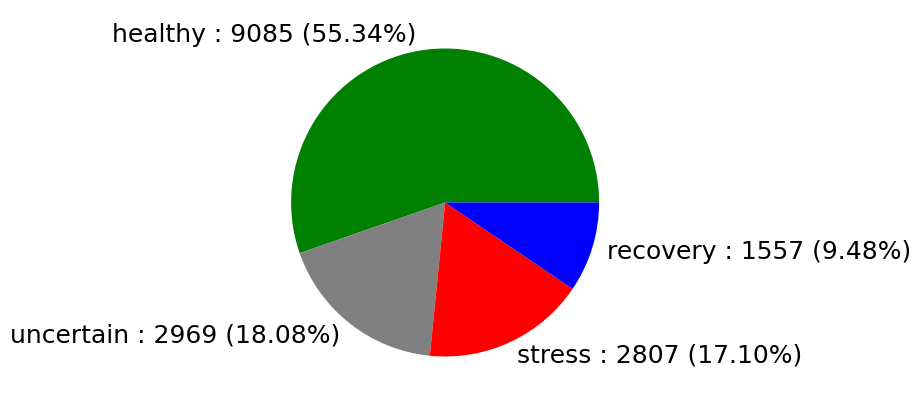

In [24]:
out = rawdata['label'].value_counts()
labs = []
s = sum(out)/100

for i in range(len(out)):
    labs.append(f"{out.index[i]} : {out[i]} ({out[i]/s:.2f}%)")
    
plt.figure(figsize=(10,5) )
plt.pie(out, labels = labs, colors=['green', 'gray', 'red', 'blue'], textprops={'fontsize': 18})
plt.savefig('label_pie.png')

## Data interpolation

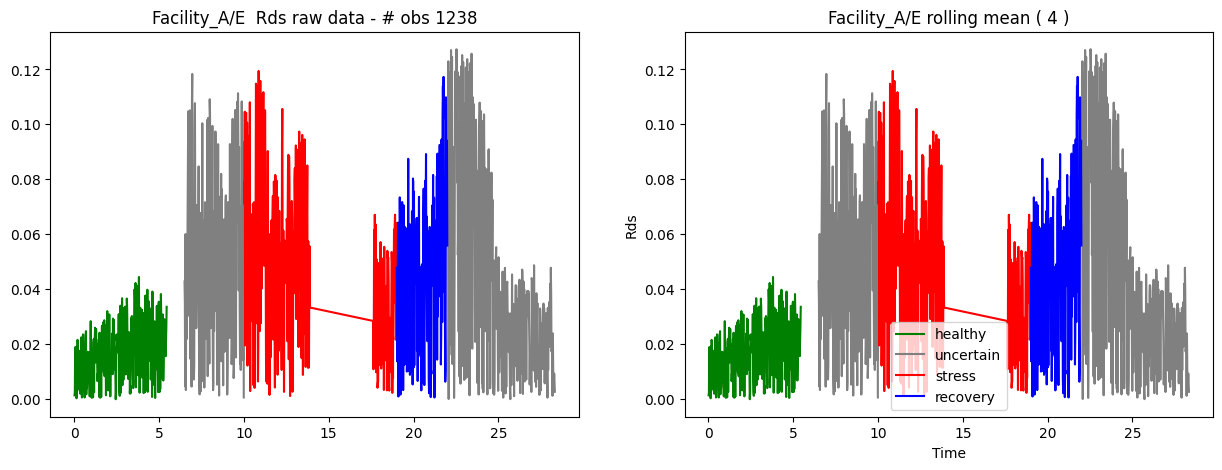

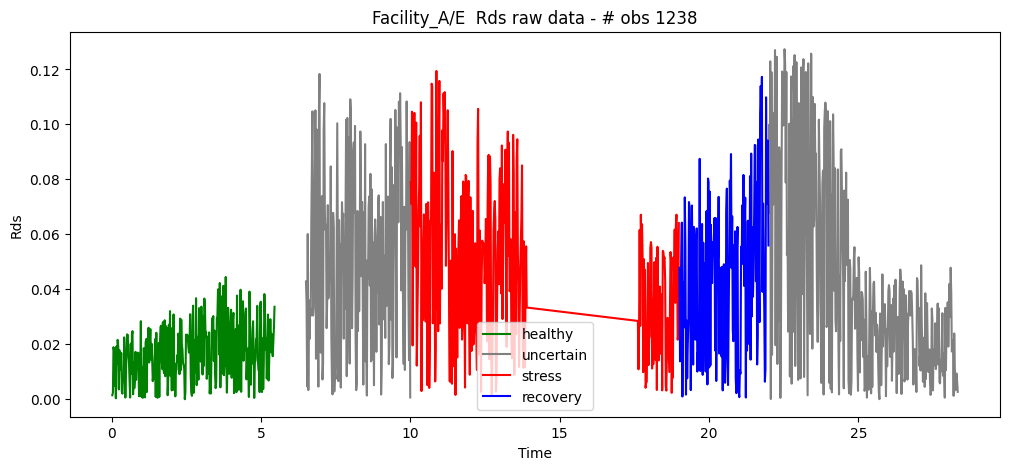

In [34]:
plotPlant(rawdata, 'Facility_A', 'E', 'Rds', nsteps=4, figSize=(15,5))
plotPlant(rawdata, 'Facility_A', 'E', 'Rds', figSize=(12,5))

In [26]:
for target in ['Rds', 'DIgs', 'tds', 'tgs']:
    nNa = rawdata[target].isna().sum() 
    print(f"Number of N.A. observations for {target:7s} : {nNa:4d} ( {nNa/rawdata.shape[0]*100:.2f}% )")

Number of N.A. observations for Rds     :  765 ( 4.66% )
Number of N.A. observations for DIgs    :  765 ( 4.66% )
Number of N.A. observations for tds     :  765 ( 4.66% )
Number of N.A. observations for tgs     :  765 ( 4.66% )


<Axes: >

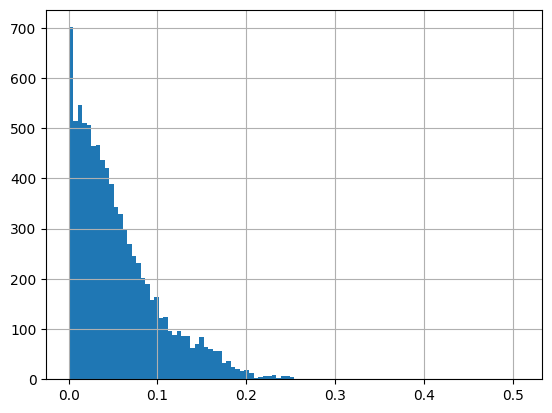

In [27]:
rawdata[rawdata.label=='healthy']['Rds'].hist(bins=100)

In [29]:
dataInterp = rawdata.interpolate(method='from_derivatives')

C:\Users\Matheus\AppData\Local\Temp\ipykernel_1276\1205296273.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  dataInterp = rawdata.interpolate(method='from_derivatives')


In [30]:
dataInterp.describe()

,Day,Rds,DIgs,tds,tgs
count,16418.000000,1.641800e+04,1.641800e+04,16418.000000,16418.000000
mean,12.704003,4.670426e-02,1.324342e-06,50.773609,15.054496
std,7.838070,4.570493e-02,1.229323e-06,50.394582,11.218987
min,0.010829,5.474077e-07,-1.111329e-09,0.005199,0.004252
25%,5.990456,1.177905e-02,2.684889e-07,18.548013,7.084281
50%,11.808032,3.368040e-02,1.045878e-06,38.845910,13.754342
75%,19.543818,6.781095e-02,2.052613e-06,68.231478,21.101272
max,28.331003,5.075905e-01,1.595630e-05,712.981649,169.340643


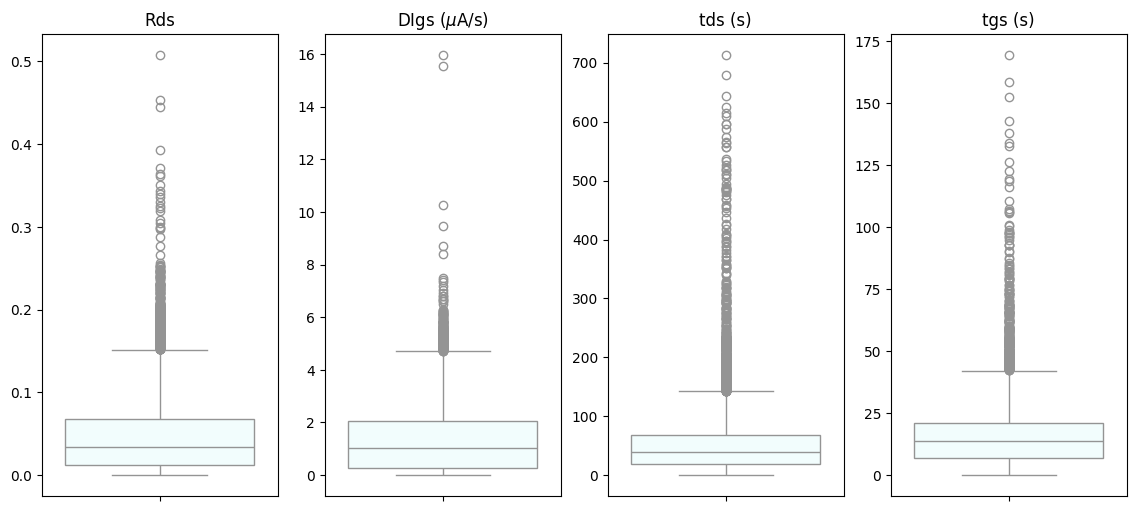

In [31]:
df = dataInterp.copy();

df['DIgs']=1000000*df['DIgs']

selection = ['Rds', 'DIgs','tds', 'tgs']
unit = [None, '$\mu$A/s','s','s']

# selection = ['Rds', tds]

# fig, axes = plt.subplots(1, len(selection))
plt.figure(figsize=(14,6))

for i, col in enumerate(selection):
    plt.subplot(1,len(selection), i+1)
    ax = sns.boxplot(y=df[col], color='azure')
    if unit[i] is not None:
        ax.set_title(f"{col} ({unit[i]})")
    else:
        ax.set_title(f"{col}")
        
    ax.set_ylabel("")

plt.savefig('summary.png')
plt.show();

In [32]:
# FIX unfeasible negative values
dataInterp.DIgs[dataInterp.DIgs<0]=0
dataInterp.describe()
# dataInterp.to_csv('AI_Pecori15min - dati grezzi - interpolated.csv')

C:\Users\Matheus\AppData\Local\Temp\ipykernel_1276\2544157964.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataInterp.DIgs[dataInterp.DIgs<0]=0
C:\Users\Matheus\AppData\Local\Temp\ipykernel_1276\2544157964.py:2: SettingWithCopyWarning

,Day,Rds,DIgs,tds,tgs
count,16418.000000,1.641800e+04,1.641800e+04,16418.000000,16418.000000
mean,12.704003,4.670426e-02,1.324343e-06,50.773609,15.054496
std,7.838070,4.570493e-02,1.229321e-06,50.394582,11.218987
min,0.010829,5.474077e-07,0.000000e+00,0.005199,0.004252
25%,5.990456,1.177905e-02,2.684889e-07,18.548013,7.084281
50%,11.808032,3.368040e-02,1.045878e-06,38.845910,13.754342
75%,19.543818,6.781095e-02,2.052613e-06,68.231478,21.101272
max,28.331003,5.075905e-01,1.595630e-05,712.981649,169.340643


### Plot interpolated data

<Figure size 2400x1600 with 0 Axes>

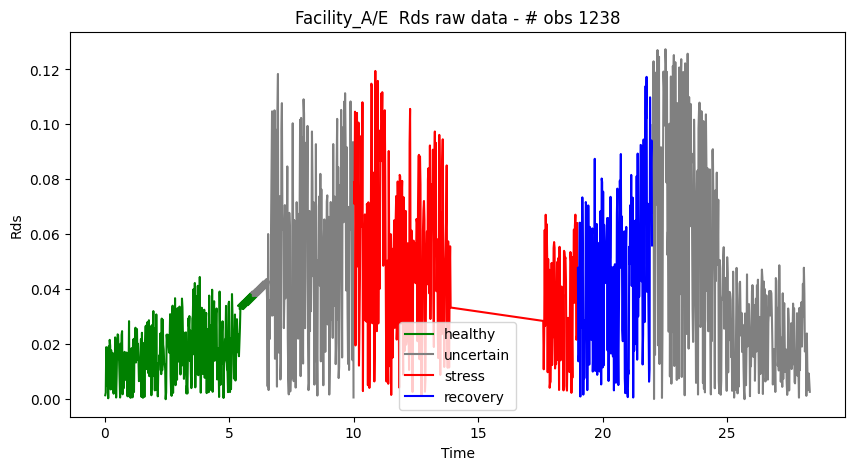

In [35]:
exp = 'Facility_A'
plant='E'

plt.figure(figsize=(24,16));

plotPlant(rawdata, exp, plant, 'Rds', dataInterp=dataInterp, figSize=(10,5))
plt.savefig('interpolation.png')
# plotPlant(rawdata, exp, plant, 'tds', dataInterp=dataInterp, figSize=(10,5))
# plotPlant(rawdata, exp, plant, 'tgs', dataInterp=dataInterp, figSize=(10,5))

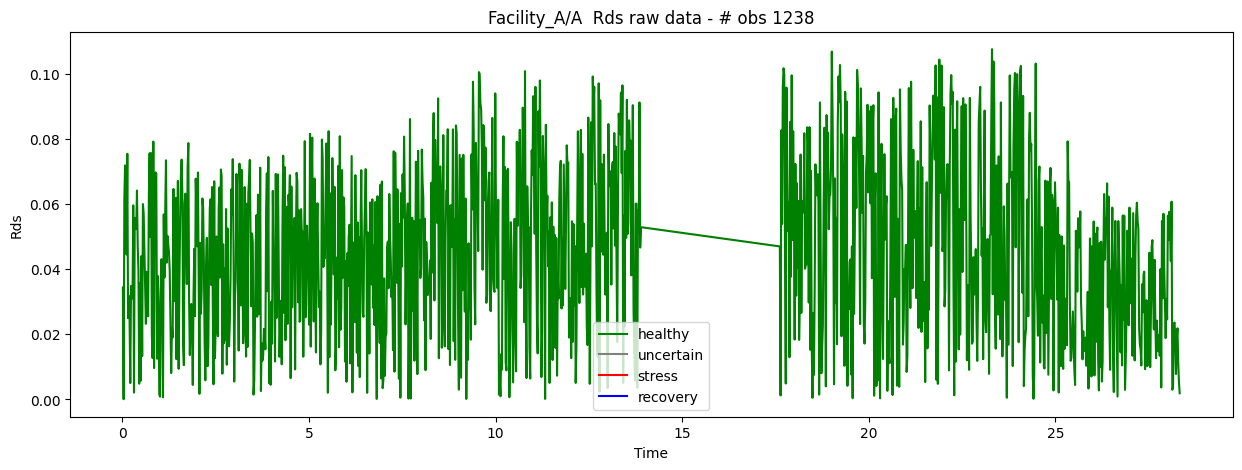

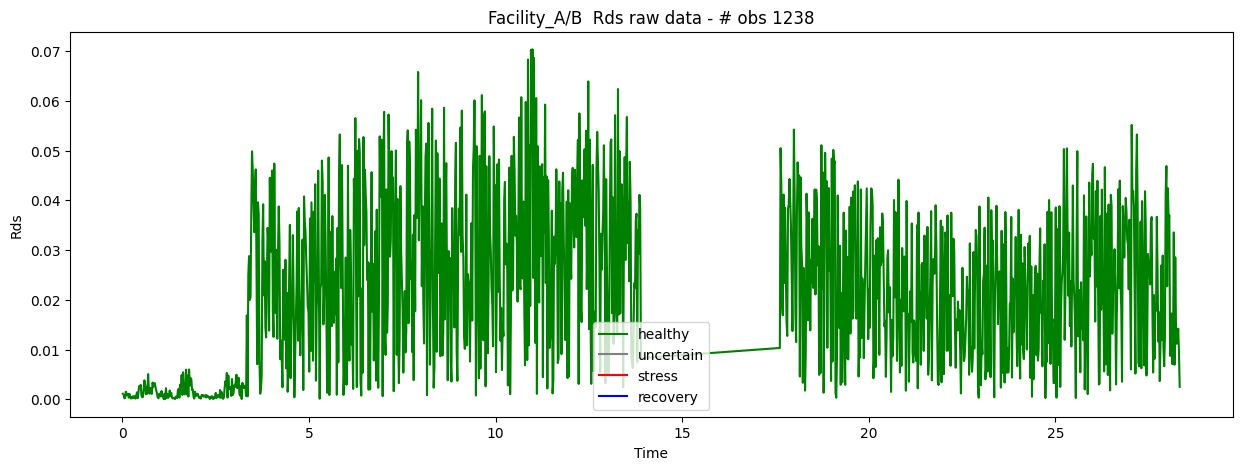

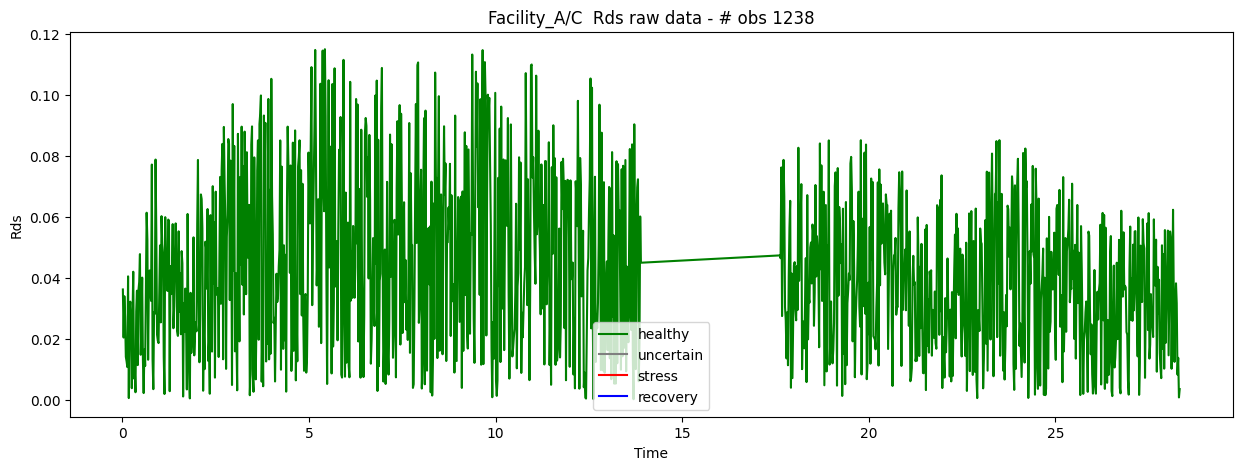

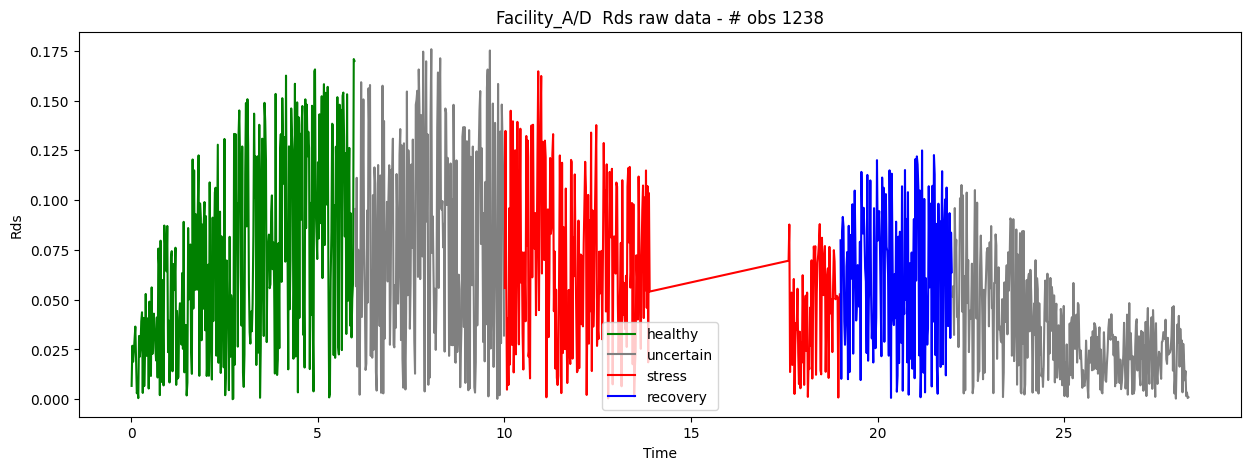

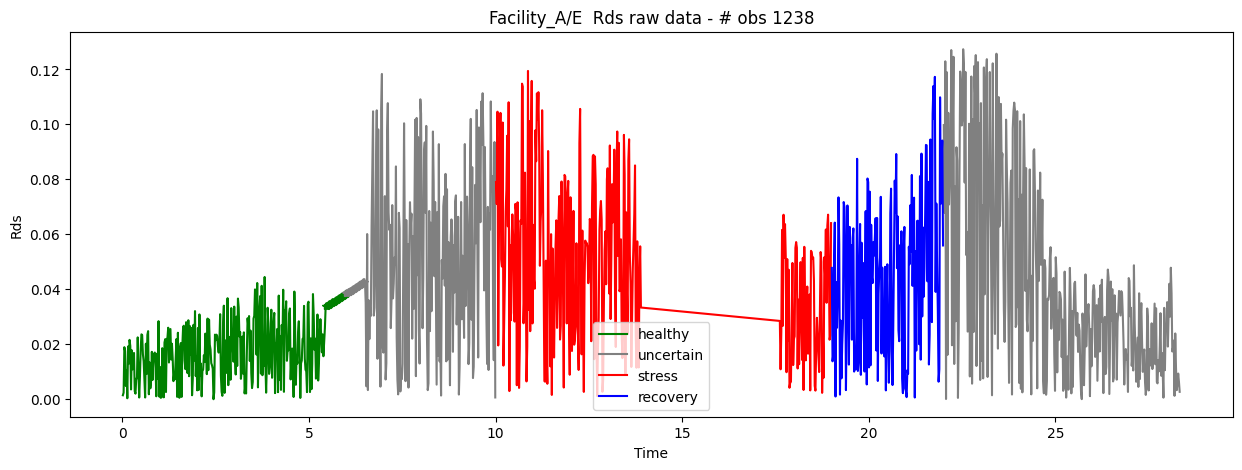

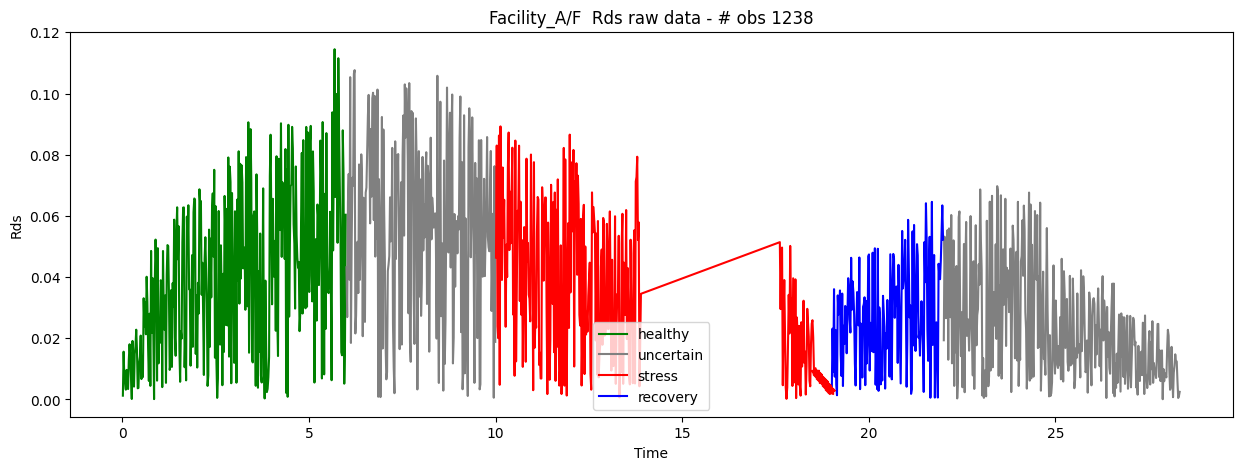

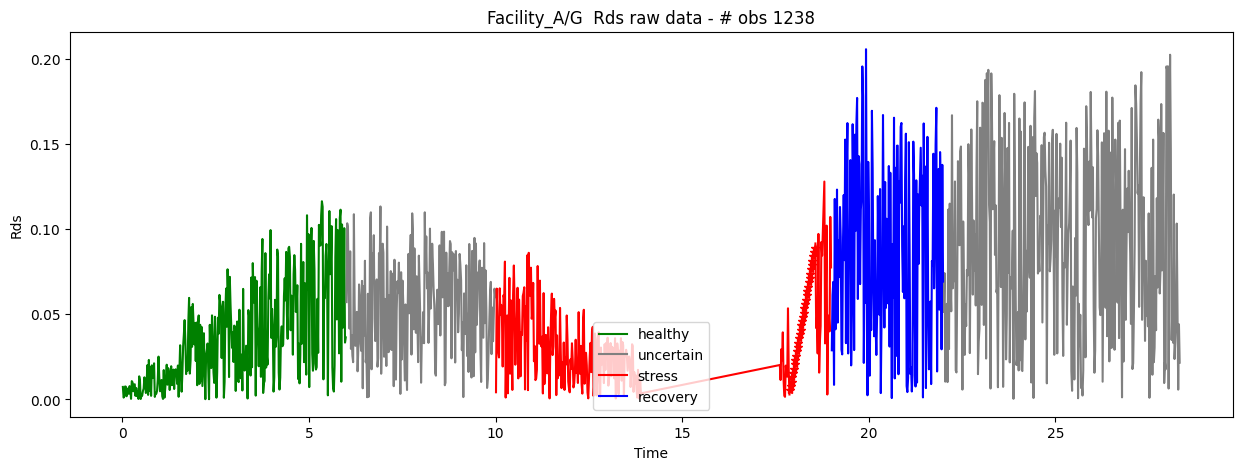

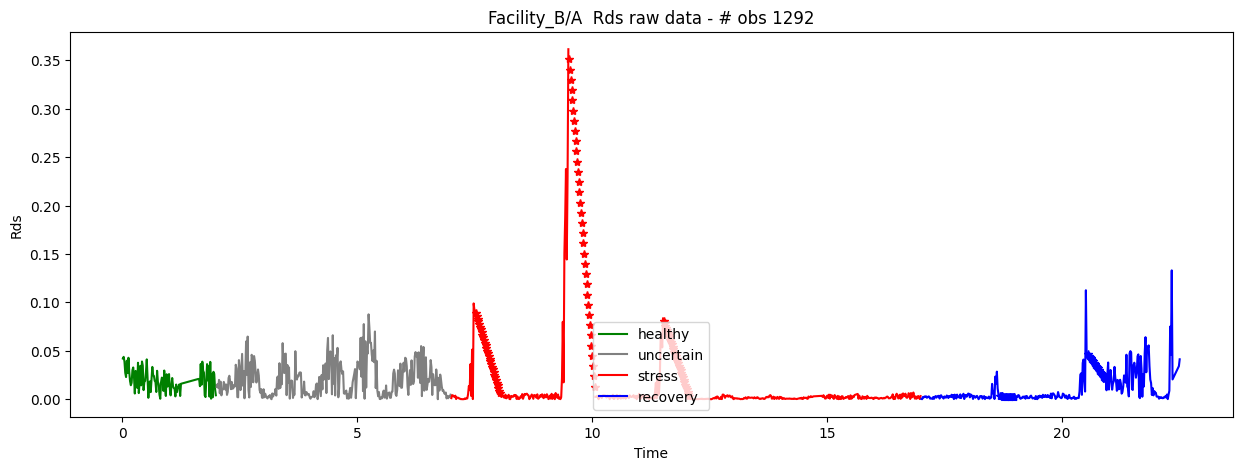

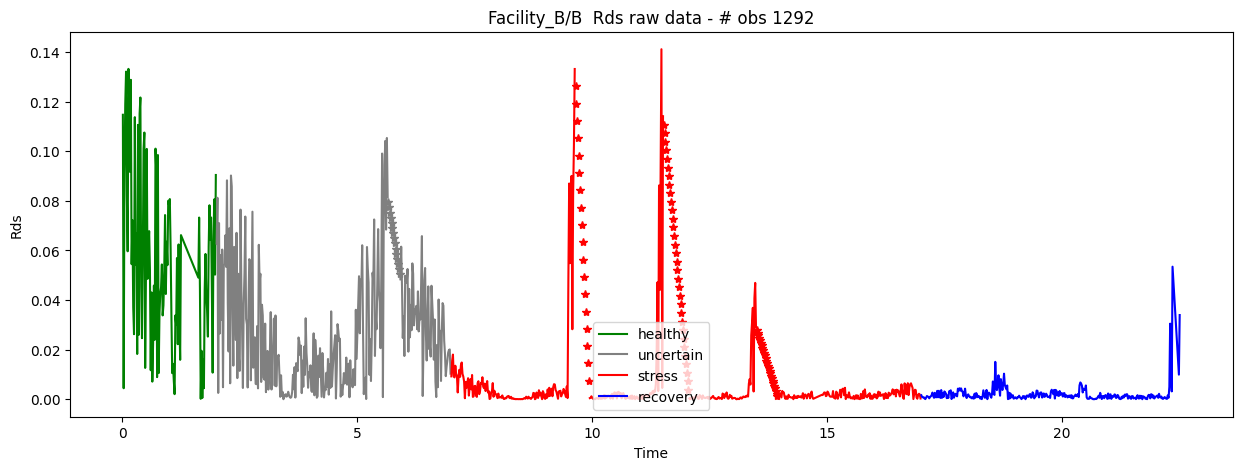

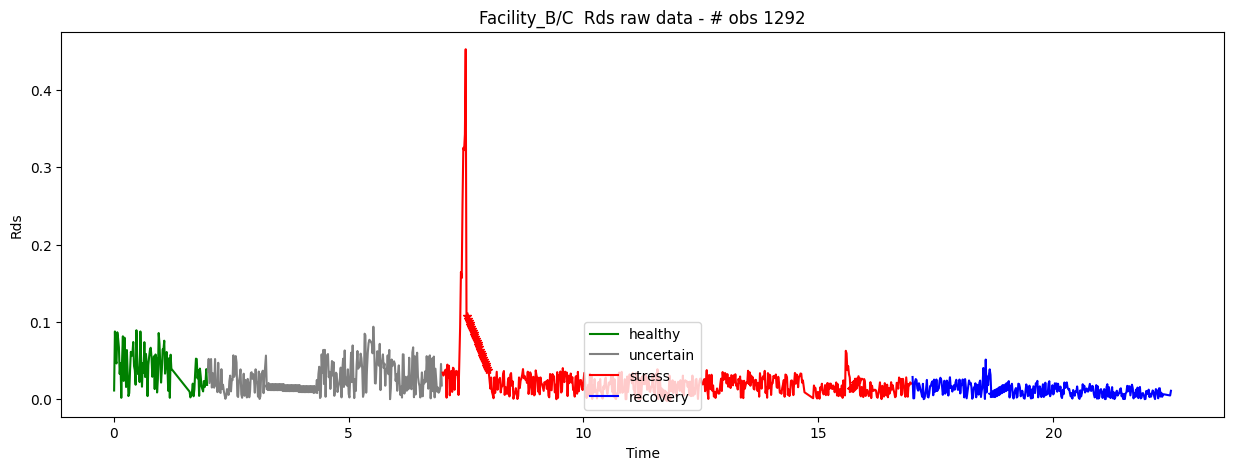

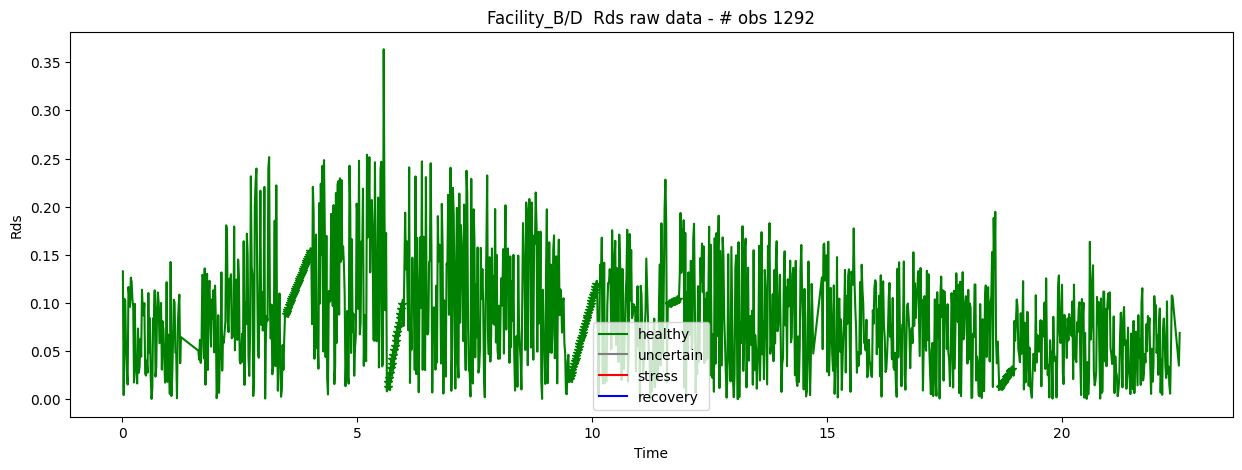

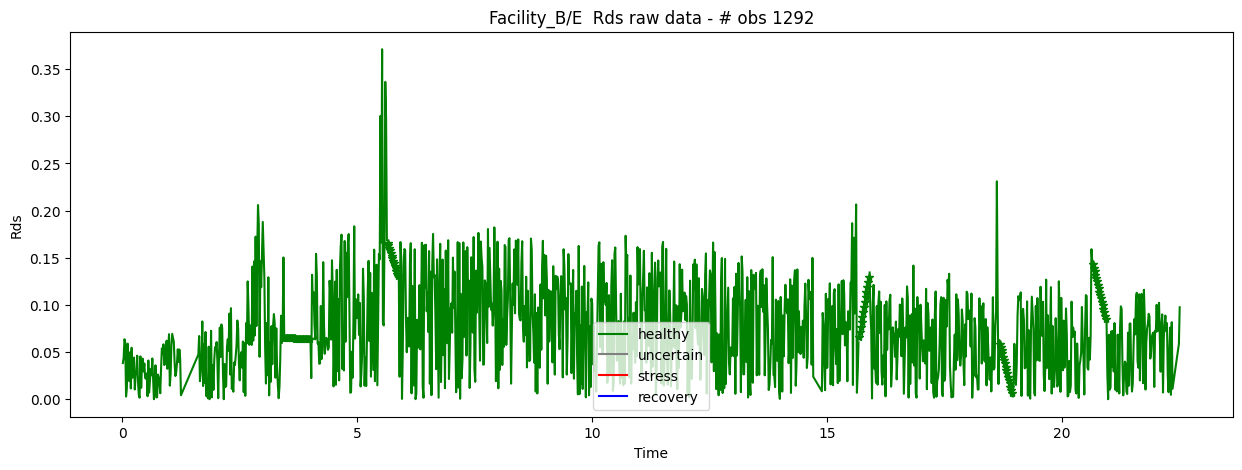

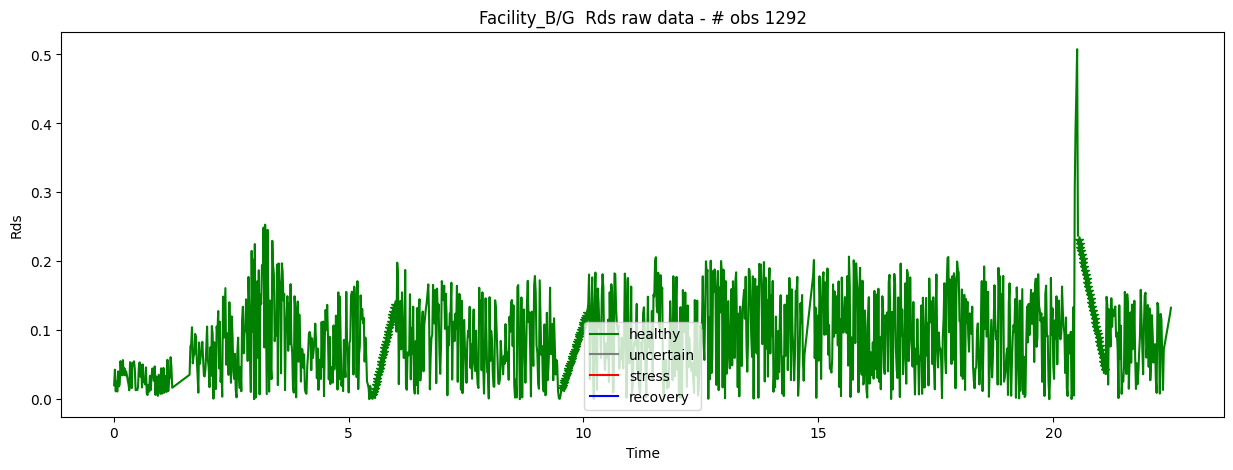

In [36]:
# Plot a parameter for all plants

target='Rds'

for e in rawdata.Exp.unique():
    for p in rawdata.Plant[rawdata.Exp==e].unique():
        plotPlant(rawdata, e, p, target, dataInterp=dataInterp, figSize=(15,5))

## Add target for one-hot enconding

In [42]:
dataInterp['target'] = dataInterp['label'].map({'healthy':0, 'uncertain':1, 'stress':2, 'recovery':3})
dataInterp.target.astype('category')
dataInterp.head()

sorted_labels = ['healthy', 'uncertain', 'stress', 'recover']

### Smoothing data on with a rolling mean (size=smoothWindow)

In [43]:
smoothWindow = 4

data = dataInterp.set_index(['Exp', 'Plant']).sort_index()
data['idx']=pd.NA
for t, gdf in data.groupby(['Exp', 'Plant']):
    data.loc[t, 'idx'] = np.arange(gdf.shape[0])
data.reset_index(inplace=True)
data.set_index(['Exp', 'Plant', 'idx'], inplace=True)
data.sort_index()

for c in ('Rds', 'DIgs', 'tds', 'tgs'):
    for t, gds in data.groupby(['Exp', 'Plant']):
        s = gds[c].rolling(smoothWindow).mean()
        data.loc[t,f"s{c}"] = s

for t, gds in data.groupby(['Exp', 'Plant']):
        s = gds['target'].rolling(smoothWindow).max().to_numpy()
        data.loc[t,'starget'] = s

### Plot individual plant/parameter

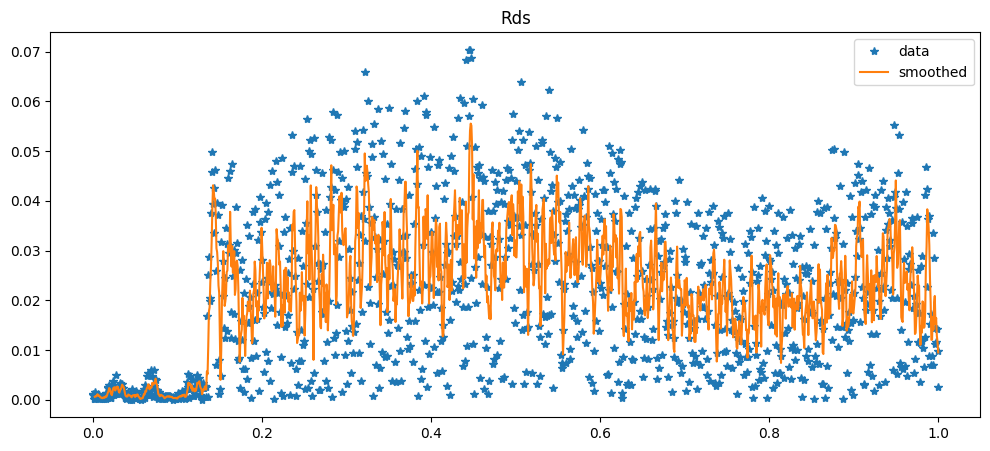

In [44]:
exp = 'Facility_A'
plant = 'B'
target = 'Rds'
starget = f"s{target}"

plt.figure(figsize=(12,5))
y = data.loc[exp,plant,:][target]
x = np.linspace(0,1,len(y))
plt.plot(x, y,'*', label='data')
ys = data.loc[exp, plant, :][starget]
x = np.linspace(0,1,len(ys))
plt.plot(x, ys, label='smoothed')
plt.title(target)
plt.legend()

In [48]:
sample = 4
shift = 0
targetCols = ['Rds', 'DIgs', 'tds', 'tgs', 'target', 'sRds', 'sDIgs', 'stds', 'stgs', 'starget']

dhour = pd.DataFrame()

dfs = []

for t, gdf in data.groupby(['Exp','Plant']):
    dfs.append(gdf[targetCols].iloc[shift::sample])

dhour = pd.concat(dfs)

dhour.loc['Facility_B','A'].head()

,Rds,DIgs,tds,tgs,target,sRds,sDIgs,stds,stgs,starget
idx,,,,,,,,,,
0,0.041972,2.767869e-08,30.951599,12.603677,0,NaN,NaN,NaN,NaN,NaN
4,0.022900,4.565195e-07,7.825589,8.047293,0,0.033205,4.135641e-07,9.797021,8.384697,0.0
8,0.028426,8.863045e-07,26.645930,6.844644,0,0.034557,7.562067e-07,34.629596,6.233891,0.0
12,0.029990,1.000458e-06,35.148015,8.866369,0,0.020058,7.029790e-07,41.569453,9.072211,0.0
16,0.029235,4.274504e-07,15.419236,4.729189,0,0.022698,5.745013e-07,45.477380,7.772341,0.0


In [49]:
dhour.dropna(inplace=True)

dhour

Rds          DIgs        tds        tgs  target  \
Exp        Plant idx                                                          
Facility_A A     4     0.068678  1.320612e-06  39.185471  15.821765       0   
                 8     0.031804  1.613626e-06  17.364135  15.505528       0   
                 12    0.033610  5.983089e-07  16.336696  15.846231       0   
                 16    0.055725  2.023865e-06  23.801275  23.204071       0   
                 20    0.047054  1.277989e-06  39.915532  18.916829       0   
...                         ...           ...        ...        ...     ...   
Facility_B G     1272  0.027514  1.281437e-07  29.595304   9.103340       0   
                 1276  0.053156  1.859713e-06  19.745978   2.927392       0   
                 1280  0.009124  1.825387e-06  13.606959  23.508403       0   
                 1284  0.008186  1.064582e-06  46.489081  17.510428       0   
                 1288  0.013444  9.672055e-07   3.263622   7.070891       0   

                           sRds         sDIgs       stds       stgs  starget  
Exp        Plant idx                                                          
Facility_A A     4     0.050592  4.930291e-07  19.057868  16.630817      0.0  
                 8     0.044164  1.344604e-06  16.554259   8.632518      0.0  
                 12    0.024550  6.304026e-07  41.917149  14.795769      0.0  
                 16    0.037111  1.394521e-06  18.320337  14.502349      0.0  
                 20    0.054242  9.078748e-07  23.779726  16.509395      0.0  
...                         ...           ...        ...        ...      ...  
Facility_B G     1272  0.085745  7.371750e-07  30.911370  10.429937      0.0  
                 1276  0.080340  9.162735e-07  28.859217   6.242754      0.0  
                 1280  0.048046  1.253748e-06  36.979189  18.305777      0.0  
                 1284  0.092764  1.079333e-06  32.238459  18.777909      0.0  
                 1288  0.079509  9.700787e-07  30.985426  20.529312      0.0  

[4095 rows x 10 columns]

### Getting a dataframe with selected lagged measures

In [50]:
nlag = 9
target = ['Rds', 'DIgs', 'tds', 'tgs', 'target']

In [51]:
data_lagged = getLags(dhour, target, nlag)

In [52]:
data_lagged.columns

Index(['Rds_8', 'Rds_7', 'Rds_6', 'Rds_5', 'Rds_4', 'Rds_3', 'Rds_2', 'Rds_1',
       'Rds_0', 'DIgs_8', 'DIgs_7', 'DIgs_6', 'DIgs_5', 'DIgs_4', 'DIgs_3',
       'DIgs_2', 'DIgs_1', 'DIgs_0', 'tds_8', 'tds_7', 'tds_6', 'tds_5',
       'tds_4', 'tds_3', 'tds_2', 'tds_1', 'tds_0', 'tgs_8', 'tgs_7', 'tgs_6',
       'tgs_5', 'tgs_4', 'tgs_3', 'tgs_2', 'tgs_1', 'tgs_0', 'target_8',
       'target_7', 'target_6', 'target_5', 'target_4', 'target_3', 'target_2',
       'target_1', 'target_0', 'target'],
      dtype='object')

### Select interesting lags

In [53]:
ok_cols = []

for c in ['Rds', 'DIgs', 'tds', 'tgs']:
    for lag in range(0, nlag, 3):
        ok_cols.append(f"{c}_{lag}")

ok_cols.append('target_0')
        
data_lagged = data_lagged[ok_cols]
data_lagged.rename(columns={'target_0':'target'}, inplace=True)

data_lagged

Rds_0     Rds_3     Rds_6        DIgs_0  \
Exp        Plant idx                                               
Facility_A A     40   0.075597  0.005787  0.033610  1.319722e-06   
                 44   0.012684  0.057148  0.055725  1.813525e-06   
                 48   0.069685  0.039205  0.047054  1.115058e-06   
                 52   0.029695  0.075597  0.005787  1.692853e-06   
                 56   0.043063  0.012684  0.057148  3.023837e-07   
...                        ...       ...       ...           ...   
Facility_B G     36   0.075581  0.021657  0.135859  6.199788e-07   
                 40   0.027514  0.158676  0.053054  1.281437e-07   
                 44   0.053156  0.106301  0.142830  1.859713e-06   
                 48   0.009124  0.075581  0.021657  1.825387e-06   
                 52   0.008186  0.027514  0.158676  1.064582e-06   

                            DIgs_3        DIgs_6      tds_0      tds_3  \
Exp        Plant idx                                                     
Facility_A A     40   1.839095e-06  5.983089e-07  13.962761  35.134838   
                 44   2.109660e-07  2.023865e-06  28.811869  42.525180   
                 48   7.056165e-07  1.277989e-06  12.772076  39.291112   
                 52   1.319722e-06  1.839095e-06  23.828062  13.962761   
                 56   1.813525e-06  2.109660e-07  25.631777  28.811869   
...                            ...           ...        ...        ...   
Facility_B G     36   1.051997e-06  5.380178e-07  32.380861   9.911006   
                 40   3.335469e-07  1.520978e-06  29.595304   1.110172   
                 44   1.385102e-06  2.129219e-06  19.745978   8.082444   
                 48   6.199788e-07  1.051997e-06  13.606959  32.380861   
                 52   1.281437e-07  3.335469e-07  46.489081  29.595304   

                          tds_6      tgs_0      tgs_3      tgs_6  target  
Exp        Plant idx                                                      
Facility_A A     40   16.336696  17.900430  16.075563  15.846231     0.0  
                 44   23.801275  18.588434  12.801801  23.204071     0.0  
                 48   39.915532  18.263194   4.345490  18.916829     0.0  
                 52   35.134838   2.322616  17.900430  16.075563     0.0  
                 56   42.525180   9.357515  18.588434  12.801801     0.0  
...                         ...        ...        ...        ...     ...  
Facility_B G     36    9.381968  26.606925  12.646679  27.509948     0.0  
                 40   15.573596   9.103340  10.721698  14.741164     0.0  
                 44   26.212503   2.927392  25.164166  10.726138     0.0  
                 48    9.911006  23.508403  26.606925  12.646679     0.0  
                 52    1.110172  17.510428   9.103340  10.721698     0.0  

[3978 rows x 13 columns]

# Neural Network models

In [77]:
nepochs = 300
patience = 15

## RNN 4 states

In [78]:
nsteps = 1
test_th = 0.2

X, Y, Y2 = getTensors(data_lagged, 'target', nsteps)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=test_th, shuffle=True)

sc = StandardScaler()
sc.fit(x_train)

x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [79]:
nLSTMs = 20

model = tf.keras.Sequential()
model.add(layers.LSTM(nLSTMs, activation='relu', input_shape=(X.shape[1], 1)))
model.add(layers.Dense(Y.shape[1], activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy',  metrics =['accuracy', 'categorical_accuracy',
                              tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall() ])

model.summary()

c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            84 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,844 (7.20 KB)

 Trainable params: 1,844 (7.20 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
y_integers = np.argmax(Y, axis=1)
weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
print('balanced class weights:', weights*2)
weights= {0:1,1:1,2:4,3:1}
print('actual class weights:',weights)

balanced class weights: [0.92553688 2.69727891 2.80807365 5.18979058]
actual class weights: {0: 1, 1: 1, 2: 4, 3: 1}


In [81]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

# model.fit(x_train, y_train, class_weight=weights, epochs=nepochs, batch_size=100, verbose=1)
# model.fit(x_train, y_train, class_weight=weights, epochs=nepochs,  verbose=1)
model_hist = model.fit(x_train, y_train, class_weight=weights, epochs=nepochs, verbose=1, callbacks=[callback])

Epoch 1/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2127 - categorical_accuracy: 0.2127 - loss: 2.0559 - precision_4: 0.2860 - recall_4: 0.0054    
Epoch 2/300
 75/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3040 - categorical_accuracy: 0.3040 - loss: 1.7113 - precision_4: 0.3560 - recall_4: 0.0455     

c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,categorical_accuracy,loss,precision_4,recall_4
  current = self.get_monitor_value(logs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3166 - categorical_accuracy: 0.3166 - loss: 1.7094 - precision_4: 0.3789 - recall_4: 0.0557
Epoch 3/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4516 - categorical_accuracy: 0.4516 - loss: 1.6218 - precision_4: 0.5359 - recall_4: 0.2473
Epoch 4/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5213 - categorical_accuracy: 0.5213 - loss: 1.5008 - precision_4: 0.5859 - recall_4: 0.3297
Epoch 5/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5205 - categorical_accuracy: 0.5205 - loss: 1.5433 - precision_4: 0.5618 - recall_4: 0.3560
Epoch 6/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5509 - categorical_accuracy: 0.5509 - loss: 1.5065 - precision_4: 0.5911 - recall_4: 0.3847
Epoch 7/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5334 - categorical_accuracy: 0.5334 - loss: 1.4975 - precision_4: 0.5760 - recall_4: 0.3491
Epoch 8/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc

In [82]:
yp = model.predict(x_test)
yp_class = np.round(yp)

sorted_labels = ['healty', 'uncertain','stress','recover']

score = model.evaluate(x_test, y_test, verbose=0)

print(f"Accuracy:  {score[1]*100:.2f}%")
print(f"Accuracy2: {score[2]*100:.2f}%")
print(f"Precision: {score[3]*100:.2f}%")
print(f"Recall:    {score[4]*100:.2f}%")

# print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(yp_class, axis=1)))

cmatrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(yp_class, axis=1))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy:  57.12%
Accuracy2: 57.12%
Precision: 60.72%
Recall:    53.22%


Text(0.5, 1.0, 'Forecast: 1 hour ahead')

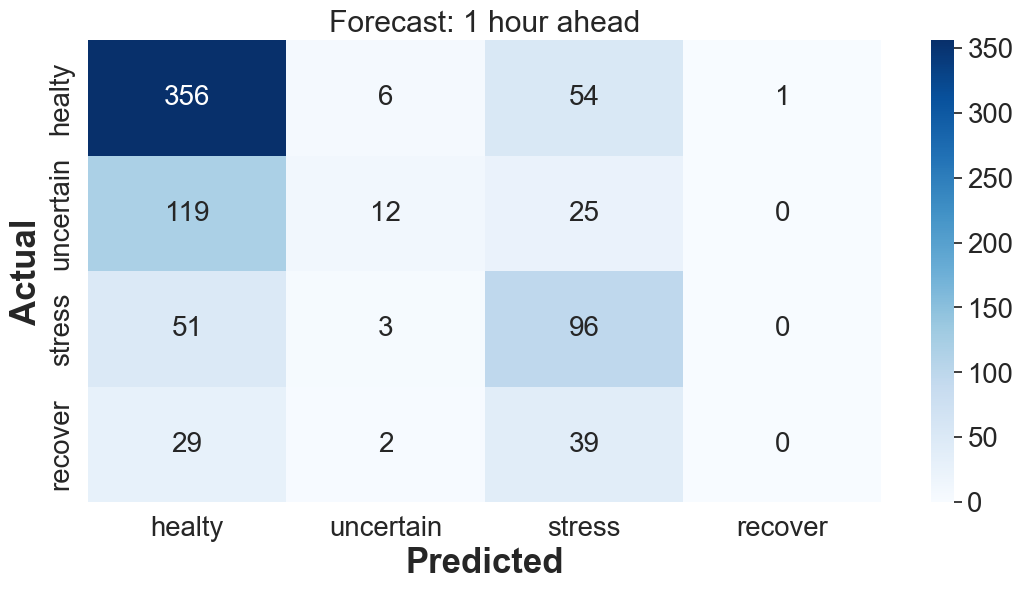

In [83]:
plt.figure(figsize=(12.8, 6))
sns.set(font_scale=1.8)
sns.heatmap(cmatrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, annot_kws={"size": 20}, cmap="Blues", fmt="g")
plt.xlabel('Predicted', fontsize = 25, weight='bold')
plt.ylabel('Actual', fontsize = 25, weight='bold')
plt.title(f'Forecast: {nsteps} hour ahead')
# sns.heatmap(cmatrix, annot=True, fmt='d', annot_kws={"fontsize": 16}, cbar=False, xticklabels=sorted_labels, yticklabels=sorted_labels,cmap='Blues');

## RNN binary modeling

In [84]:
classificator = tf.keras.Sequential()
classificator.add(layers.LSTM(nLSTMs, activation='relu', input_shape=(X.shape[1], 1)))
classificator.add(layers.Dense(1, activation='sigmoid'))
classificator.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics =['accuracy',
                              tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall() ])

classificator.summary()

c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781 (6.96 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
(x_train, x_test, y_train, y_test) = train_test_split(X, Y2, test_size=test_th, shuffle=True)

sc = StandardScaler()
sc.fit(x_train)

x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [86]:
pd.DataFrame(y_train).value_counts()

0  
0.0    2605
1.0     567
Name: count, dtype: int64

In [87]:
weights={0:1, 1:4}
# weights = {0:1, 1:1}

In [88]:
class_hist = classificator.fit(x_train, y_train.reshape(-1,1), class_weight=weights, epochs=nepochs, verbose=1, callbacks=[ callback ])
# classificator.save('RNN-binary')

Epoch 1/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5325 - loss: 1.0700 - precision_5: 0.2446 - recall_5: 0.7090
Epoch 2/300
 79/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7286 - loss: 0.9881 - precision_5: 0.3388 - recall_5: 0.5325

c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision_5,recall_5
  current = self.get_monitor_value(logs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7307 - loss: 0.9826 - precision_5: 0.3387 - recall_5: 0.5291
Epoch 3/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7402 - loss: 0.9403 - precision_5: 0.3532 - recall_5: 0.5026
Epoch 4/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7425 - loss: 0.9073 - precision_5: 0.3586 - recall_5: 0.5617
Epoch 5/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7445 - loss: 0.8958 - precision_5: 0.3434 - recall_5: 0.5268
Epoch 6/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7750 - loss: 0.8764 - precision_5: 0.3691 - recall_5: 0.4637
Epoch 7/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7480 - loss: 0.9201 - precision_5: 0.3728 - recall_5: 0.5136
Epoch 8/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7686 - loss: 0.8621 - precision_5: 0.3892 - recall_5: 0.5711
Epoch 9/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7666 - loss: 0.8597 - precision_5: 0.3693 - recal

In [89]:
yp = classificator.predict(x_test)
yp_predicted_class = np.round(yp)
score = classificator.evaluate(x_test, y_test, verbose=0)

score

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[0.554067075252533, 0.7591425180435181, 0.4000000059604645, 0.7482014298439026]

Accuracy:  75.91%
Precision: 40.00%
Recall:    74.82%


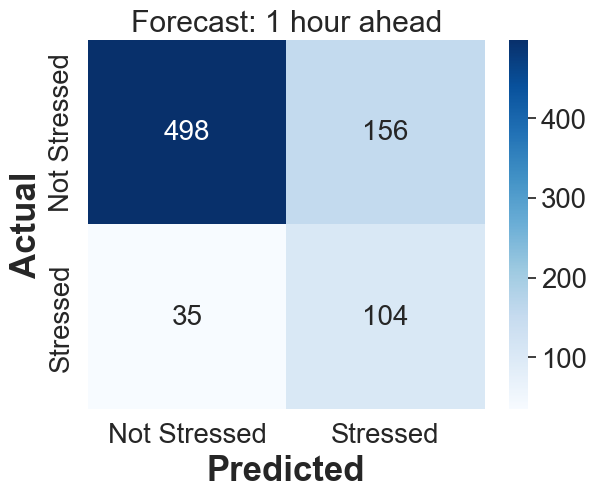

In [90]:
print(f"Accuracy:  {score[1]*100:.2f}%")
print(f"Precision: {score[2]*100:.2f}%")
print(f"Recall:    {score[3]*100:.2f}%")

cmatrix = confusion_matrix(y_test, yp_predicted_class)

sns.heatmap(cmatrix, annot=True, xticklabels=binlabels, yticklabels=binlabels, annot_kws={"size": 20}, cmap="Blues", fmt="g")
plt.xlabel('Predicted', fontsize = 25, weight='bold');
plt.ylabel('Actual', fontsize = 25, weight='bold');
plt.title(f'Forecast: {nsteps} hour ahead');

# Varying the number of ahead prediction lag

In [92]:
nsteps=24
nLSTMs = 30

X, Y, Y2 = getTensors(data_lagged, 'target', nsteps)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y2, test_size=test_th, shuffle=True)
sc = StandardScaler()
sc.fit(x_train)

x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [93]:
classificator3 = tf.keras.Sequential()
classificator3.add(layers.LSTM(nLSTMs, activation='relu', input_shape=(X.shape[1], 1)))
classificator3.add(layers.Dense(1, activation='sigmoid'))
classificator3.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', 
                        metrics =['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ])
#                        metrics =['accuracy'])

classificator3.summary()

c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30)             │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,871 (15.12 KB)

 Trainable params: 3,871 (15.12 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
class3_hist = classificator3.fit(x_train, y_train.reshape(-1,1), class_weight={0:1, 1:3}, epochs=nepochs, callbacks= [callback])

Epoch 1/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6877 - loss: 0.9503 - precision_6: 0.1726 - recall_6: 0.1740
Epoch 2/300
77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8018 - loss: 0.9056 - precision_6: 0.5531 - recall_6: 0.1603

c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision_6,recall_6
  current = self.get_monitor_value(logs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7971 - loss: 0.9055 - precision_6: 0.5249 - recall_6: 0.1807
Epoch 3/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7460 - loss: 0.8971 - precision_6: 0.3940 - recall_6: 0.4169
Epoch 4/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7520 - loss: 0.8862 - precision_6: 0.3851 - recall_6: 0.3763
Epoch 5/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7630 - loss: 0.8765 - precision_6: 0.3791 - recall_6: 0.3652
Epoch 6/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7574 - loss: 0.8996 - precision_6: 0.3708 - recall_6: 0.3321
Epoch 7/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7408 - loss: 0.8939 - precision_6: 0.3555 - recall_6: 0.3818
Epoch 8/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7672 - loss: 0.8664 - precision_6: 0.3931 - recall_6: 0.3661
Epoch 9/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7718 - loss: 0.8578 - precision_6: 0.3986 - recall_6: 0.3464     

In [95]:
yp = classificator3.predict(x_test)
yp_class = np.round(yp)
score = classificator3.evaluate(x_test, y_test, verbose=0)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [96]:
print(f"Accuracy:  {score[1]*100:.2f}%")
print(f"Precision: {score[2]*100:.2f}%")
print(f"Recall:    {score[3]*100:.2f}%")

Accuracy:  72.48%
Precision: 35.54%
Recall:    65.15%


In [97]:
print(confusion_matrix(y_test, yp_class))

[[446 156]
 [ 46  86]]


In [98]:
nsteps=24
nLSTMs = 15

X, Y, Y2 = getTensors(data_lagged, 'target', nsteps)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y2, test_size=test_th, shuffle=True)
sc = StandardScaler()
sc.fit(x_train)

x_train = sc.transform(x_train)
x_test = sc.transform(x_test)


In [99]:
x_train.shape, y_train.shape


((2932, 12), (2932,))

In [100]:
classificator4 = tf.keras.Sequential()
classificator4.add(layers.LSTM(nLSTMs, activation='relu', input_shape=(X.shape[1], 1)))
classificator4.add(layers.Dense(1, activation='sigmoid'))
classificator4.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', 
                       metrics =['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ])

classificator4.summary()
class4_hist = classificator4.fit(x_train, y_train.reshape(-1,1), epochs=300, callbacks=[callback])
yp = classificator4.predict(x_test)
yp_class = np.round(yp)
score = classificator4.evaluate(x_test, y_test, verbose=0)

c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 15)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,036 (4.05 KB)

 Trainable params: 1,036 (4.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6769 - loss: 0.6565 - precision_7: 0.1860 - recall_7: 0.1829
Epoch 2/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8165 - loss: 0.4912 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00


c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision_7,recall_7
  current = self.get_monitor_value(logs)


Epoch 3/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7997 - loss: 0.4856 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 4/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7988 - loss: 0.4797 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 5/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8080 - loss: 0.4525 - precision_7: 0.1792 - recall_7: 0.0016      
Epoch 6/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7951 - loss: 0.4649 - precision_7: 0.1355 - recall_7: 0.0055      
Epoch 7/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8112 - loss: 0.4552 - precision_7: 0.5643 - recall_7: 0.0811      
Epoch 8/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8069 - loss: 0.4549 - precision_7: 0.5403 - recall_7: 0.0940
Epoch 9/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8076 - loss: 0.4529 - precision_7: 0.4130 - recall_7: 0.0527      
Epoch 10/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8179 - loss:

In [101]:
# print(f"Accuracy {score[1]*100:.2f}%")
print(f"Accuracy:  {score[1]*100:.2f}%")
print(f"Precision: {score[2]*100:.2f}%")
print(f"Recall:    {score[3]*100:.2f}%")

Accuracy:  84.47%
Precision: 63.64%
Recall:    27.13%


In [102]:
print(confusion_matrix(y_test, yp_class))

[[585  20]
 [ 94  35]]


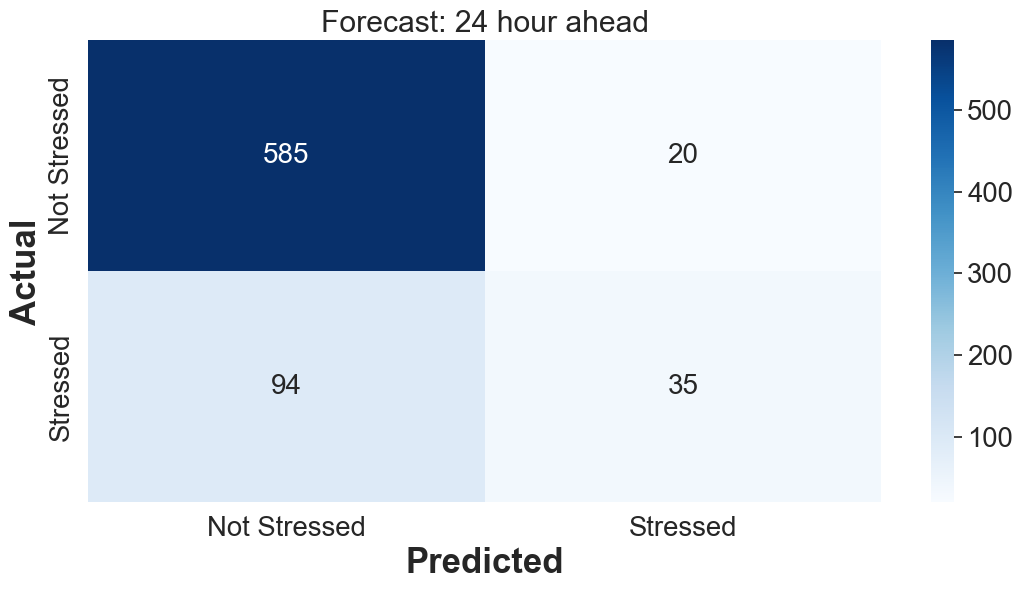

In [103]:
cmatrix = confusion_matrix(y_test, yp_class)

plt.figure(figsize=(12.8, 6))
sns.set(font_scale=1.8)
sns.heatmap(cmatrix, annot=True, xticklabels=binlabels, yticklabels=binlabels, annot_kws={"size": 20}, cmap="Blues", fmt="g")
plt.xlabel('Predicted', fontsize = 25, weight='bold');
plt.ylabel('Actual', fontsize = 25, weight='bold');
plt.title(f'Forecast: {nsteps} hour ahead');

plt.savefig('RNN-binary-48h-cmatrix.png')

In [104]:
cmatrix

array([[585,  20],
       [ 94,  35]], dtype=int64)

### 24 hours forcasting on four states

In [105]:
nsteps=24
nLSTMs = 30

X, Y, Y2 = getTensors(data_lagged, 'target', nsteps)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=test_th, shuffle=True)
sc = StandardScaler()
sc.fit(x_train)

x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [106]:
model24h = tf.keras.Sequential()
model24h.add(layers.LSTM(nLSTMs, activation='relu', input_shape=(X.shape[1], 1)))
model24h.add(layers.Dense(Y.shape[1], activation='softmax'))
model24h.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', 
                 metrics =['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ])
model24h.summary()

c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 30)             │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,964 (15.48 KB)

 Trainable params: 3,964 (15.48 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
weights= {0:1,1:1,2:4,3:1}

model24h_hist = model24h.fit(x_train, y_train, class_weight=weights, epochs=nepochs, callbacks=[callback], verbose=1)

Epoch 1/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2064 - loss: 2.1552 - precision_8: 0.1468 - recall_8: 0.0075       
Epoch 2/300
71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2140 - loss: 1.8402 - precision_8: 0.3315 - recall_8: 0.0877

c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision_8,recall_8
  current = self.get_monitor_value(logs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2140 - loss: 1.8328 - precision_8: 0.3289 - recall_8: 0.0871
Epoch 3/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2643 - loss: 1.7710 - precision_8: 0.3358 - recall_8: 0.0994
Epoch 4/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3857 - loss: 1.6305 - precision_8: 0.4731 - recall_8: 0.2058
Epoch 5/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4159 - loss: 1.6074 - precision_8: 0.5125 - recall_8: 0.2092
Epoch 6/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4022 - loss: 1.6182 - precision_8: 0.4680 - recall_8: 0.2245
Epoch 7/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3857 - loss: 1.6495 - precision_8: 0.4222 - recall_8: 0.1956
Epoch 8/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4180 - loss: 1.6011 - precision_8: 0.4762 - recall_8: 0.2378
Epoch 9/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4494 - loss: 1.5398 - precision_8: 0.5244 - recall_8: 0.2817
Epoc

In [108]:
yp = model24h.predict(x_test)
yp_class = np.round(yp)
score = model24h.evaluate(x_test, y_test, verbose=0)
cmatrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(yp_class, axis=1))

# print(f"Accuracy {score[1]*100:.2f}%")

f1 = 2 *(score[2]*score[3]) / (score[3]+score[3])

print(f"Accuracy:  {score[1]*100:.2f}%")
print(f"Precision: {score[2]*100:.2f}%")
print(f"Recall:    {score[3]*100:.2f}%")
print(f"Recall:    {f1*100:.2f}%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy:  53.00%
Precision: 54.53%
Recall:    46.73%
Recall:    54.53%


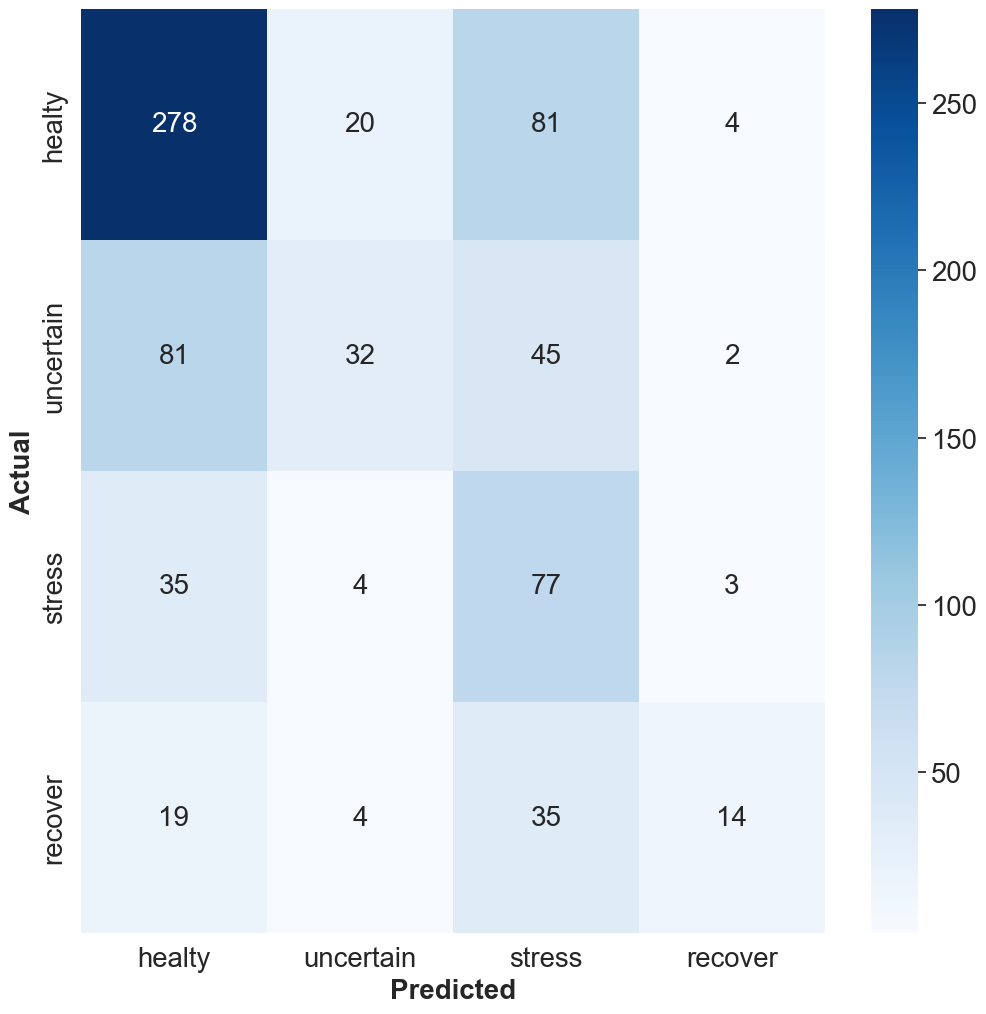

In [109]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.8)
sns.heatmap(cmatrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, annot_kws={"size": 20}, cmap="Blues", fmt="g")
plt.xlabel('Predicted', fontsize = 20, weight='bold')
plt.ylabel('Actual', fontsize = 20, weight='bold')
# plt.title(f'Forecast: {nsteps} hour ahead')
plt.savefig('RNN-4states-24h-cmatrix.png')

In [110]:
plt.savefig('RNN-4states-24h-cmatrix.png');

<Figure size 640x480 with 0 Axes>

### KFold cross validation

In [111]:
kf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 
# kf = KFold(n_splits = 5, random_state = 7, shuffle = True)

In [112]:
weights= {0:1,1:1,2:4,3:1}

scores4 = list()
fold_id=1

for train, test in kf.split(X, Y2):
    x_train = X[train,]
    y_train = Y[train,]
    x_test = X[test,]
    y_test = Y[test,]
    
    sc = StandardScaler()
    sc.fit(x_train)

    x_train = sc.transform(x_train)
    x_test = sc.transform(x_test)
    
    print(f"\t processing fold {fold_id}")
    
    model24hf = tf.keras.Sequential()
    model24hf.add(layers.LSTM(nLSTMs, activation='relu', input_shape=(X.shape[1], 1)))
    model24hf.add(layers.Dense(Y.shape[1], activation='softmax'))
    model24hf.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', 
                 metrics =['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ])
    

    model24h_hist = model24hf.fit(x_train, y_train, class_weight=weights, epochs=nepochs, callbacks=[callback], verbose=0)
    
    yp = model24hf.predict(x_test, verbose=0)
    yp_class = np.round(yp)
    score = model24hf.evaluate(x_test, y_test, verbose=0)


    
    scores4.append( (score, model24hf, class_hist))
    
    fold_id = fold_id + 1
    
print('\t done')

	 processing fold 1


c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision_9,recall_9
  current = self.get_monitor_value(logs)


	 processing fold 2


c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision_10,recall_10
  current = self.get_monitor_value(logs)


	 processing fold 3


c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision_11,recall_11
  current = self.get_monitor_value(logs)


	 processing fold 4


c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision_12,recall_12
  current = self.get_monitor_value(logs)


	 processing fold 5


c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision_13,recall_13
  current = self.get_monitor_value(logs)


	 done


In [113]:
metric = ('accuracy', 'precison', 'recall','f-measure')

for i in (1,2,3):
    l=[ x[0][i]*100 for x in scores4 ] 
    print(f"{metric[i-1]:10} {np.mean(l):.4}  {np.std(l):.4}")

f1 = [ 2*x[0][2]*x[0][3]/(x[0][2]+x[0][3])*100 for x in scores4 ]

print(f"{metric[3]:10} {np.mean(f1)}  {np.std(f1)}")


accuracy   52.95  1.175
precison   54.94  1.433
recall     47.65  2.495
f-measure  51.02575860506636  1.9987490361119267


### 24 hours forcasting (2 states)

In [114]:
nahead = 4*3
test_th = 0.2

nLSTM=20

X, Y, Y2 = getTensors(data_lagged, 'target', nahead)

model24h2 = tf.keras.Sequential()
model24h2.add(layers.LSTM(nLSTM, activation='relu', input_shape=(X.shape[1], 1)))
model24h2.add(layers.Dense(1, activation='sigmoid'))
model24h2.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics =['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ])

model24h2.summary()

c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781 (6.96 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
weights = {0:1, 1:1}

(x_train, x_test, y_train, y_test) = train_test_split(X, Y2, test_size=test_th, shuffle=True)

sc = StandardScaler()
sc.fit(x_train)

x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [116]:
class_hist_model24h2 = model24h2.fit(x_train, y_train.reshape(-1,1), class_weight=weights, epochs=nepochs, callbacks=[callback], verbose=1)

Epoch 1/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8239 - loss: 0.6066 - precision_14: 0.3465 - recall_14: 0.0302
Epoch 2/300
81/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8129 - loss: 0.4666 - precision_14: 0.0000e+00 - recall_14: 0.0000e+00

c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision_14,recall_14
  current = self.get_monitor_value(logs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8129 - loss: 0.4657 - precision_14: 0.0000e+00 - recall_14: 0.0000e+00
Epoch 3/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8154 - loss: 0.4374 - precision_14: 0.3463 - recall_14: 0.0088      
Epoch 4/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8196 - loss: 0.4335 - precision_14: 0.5176 - recall_14: 0.0707     
Epoch 5/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8191 - loss: 0.4409 - precision_14: 0.6242 - recall_14: 0.1546      
Epoch 6/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8326 - loss: 0.4120 - precision_14: 0.6394 - recall_14: 0.1698
Epoch 7/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8209 - loss: 0.4354 - precision_14: 0.5710 - recall_14: 0.1976
Epoch 8/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8290 - loss: 0.4193 - precision_14: 0.6234 - recall_14: 0.2051
Epoch 9/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8337 - loss: 0.4023 - prec

In [117]:
yp = model24h2.predict(x_test)
yp_predict_class = np.round(yp)
score = model24h2.evaluate(x_test, y_test, verbose=0)

# print(f"Accuracy {score[1]*100:.2f}%")
f1 = 2 *(score[2]*score[3]) / (score[3]+score[3])

print(f"Accuracy:  {score[1]*100:.2f}%")
print(f"Precision: {score[2]*100:.2f}%")
print(f"Recall:    {score[3]*100:.2f}%")
print(f"F1:        {f1*100:.2f}%")


print(confusion_matrix(y_test, yp_predict_class))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy:  82.22%
Precision: 49.50%
Recall:    37.04%
F1:        49.50%
[[579  51]
 [ 85  50]]


### K-Fold cross validation

In [118]:
kf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 
# kf = KFold(n_splits = 5, random_state = 7, shuffle = True)

In [119]:
scores2 = list()

fold_id=1

for train, test in kf.split(X, Y2):
    x_train = X[train,]
    y_train = Y2[train,]
    x_test = X[test,]
    y_test = Y2[test,]
    
    sc = StandardScaler()
    sc.fit(x_train)

    x_train = sc.transform(x_train)
    x_test = sc.transform(x_test)
    
    print(f"\t processing fold {fold_id}")
    
    model24h2f = tf.keras.Sequential()
    model24h2f.add(layers.LSTM(nLSTM, activation='relu', input_shape=(X.shape[1], 1)))
    model24h2f.add(layers.Dense(1, activation='sigmoid'))
    model24h2f.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics =['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ])
    class_hist = model24h2f.fit(x_train, y_train.reshape(-1,1), class_weight=weights, epochs=nepochs, callbacks=[callback], verbose=0)
    
    yp = model24h2f.predict(x_test, verbose=0)
    yp_predict_class = np.round(yp)
    score = model24h2f.evaluate(x_test, y_test, verbose=0)
    
    scores2.append( (score, model24h2f, class_hist))
    
    fold_id = fold_id + 1
    
print('\t done')

	 processing fold 1


c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision_15,recall_15
  current = self.get_monitor_value(logs)


	 processing fold 2


c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision_16,recall_16
  current = self.get_monitor_value(logs)


	 processing fold 3


c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision_17,recall_17
  current = self.get_monitor_value(logs)


	 processing fold 4


c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision_18,recall_18
  current = self.get_monitor_value(logs)


	 processing fold 5


c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Matheus\Documents\Repositories\ForecastingWaterStress\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision_19,recall_19
  current = self.get_monitor_value(logs)


	 done


In [120]:
metric = ('accuracy', 'precison', 'recall','f-measure')

for i in (1,2,3):
    l=[ x[0][i]*100 for x in scores4 ] 
    print(f"{metric[i-1]:10} {np.mean(l):.4}  {np.std(l):.4}")

f1 = [ 2*x[0][2]*x[0][3]/(x[0][2]+x[0][3])*100 for x in scores2 ]

print(f"{metric[3]:10} {np.mean(f1)}  {np.std(f1)}")


accuracy   52.95  1.175
precison   54.94  1.433
recall     47.65  2.495
f-measure  44.39940858155783  4.376419775467929


In [121]:
metric = ('accuracy', 'precison', 'recall','f-measure')
for i in (1,2,3):
    l=[ x[0][i]*100 for x in scores2 ] 
    print(f"{metric[i-1]:10} {np.mean(l):.4}  {np.std(l):.4}")

f1 = [ 2*x[0][2]*x[0][3]/(x[0][2]+x[0][3])*100 for x in scores2 ]

print(f"{metric[3]:10} {np.mean(f1):.4}  {np.std(f1):.4}")

accuracy   84.35  0.712
precison   64.93  5.052
recall     34.14  5.434
f-measure  44.4  4.376
